In [571]:
# Big Data Ex1 Avlas Kfir 060519071
#---------------------------------------

# import needed libraries

from pyspark.sql import SparkSession, DataFrame
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pn # For visualization
import seaborn as sns

In [572]:
# Print dataFrame details

def print_information(p_data: DataFrame):
    print("Schema :")
    p_data.printSchema()
    print("Number of rows: " + str(p_data.count()))
    print("Example row :")
    p_data.show(1)

In [573]:
# Read csv file using spark sql API

def read_file(p_path: str):
    return spark.read.csv(p_path, inferSchema=True, header=True)

In [575]:
# Query by sql command, create new temp view and return a new dataFrame 

def query_data(p_sql: str, p_view_name: str):
    df = spark.sql(p_sql)
    df.createOrReplaceTempView(p_view_name)
    
    return df

In [576]:
# Create covid19 main dataFrame and initial view

def read_covid19_data():
    data = read_file("/home/spark-vm/PycharmProjects/BigDataCource/covid19.csv")
    data.createOrReplaceTempView("xx_covid19_init_v")
    
    return data

In [577]:
# Create stock (s&p500) main dataFrame and initial view

def read_stock_data():
    data = read_file("/home/spark-vm/PycharmProjects/BigDataCource/stock.csv")
    data.createOrReplaceTempView("xx_stock_init_v")
    
    return data

In [578]:
# Create Influenza main dataFrame and initial view

def read_influenza_data():
    data = read_file("/home/spark-vm/PycharmProjects/BigDataCource/influenza.csv")
    data.createOrReplaceTempView("xx_influenza_init_v")
    
    return data

In [579]:
# Generating visualizations with pyplot.
#---------------------------------------

# 1. Show x,y and z dataFrames values distribution plot

def distribution(x: pn.DataFrame, xname: str, y: pn.DataFrame, yname: str,  
                 z: pn.DataFrame = None, zname: str = "", p_title: str = "", p_format_date: bool = True):
    plt.style.use("seaborn")
    plt.plot(x, y)
    if z is not None:
        if not z.empty:
            plt.plot(x, z)
    if p_format_date:
        plt.gcf().axes[0].xaxis.set_major_formatter(DateFormatter('%d-%m'))
    plt.title(p_title)
    plt.legend([yname, zname], loc = "upper left")
    plt.xlabel(xname)
    plt.ylabel(yname + "/" + zname)

In [581]:
# 2. Show a dataFrame value box plot

def box_plot(x1: pn.DataFrame, x1name: str, x2: pn.DataFrame = None, x2name: str = "", p_title: str = "", p_desc: str = ""):
    fig, ax = plt.subplots(1, 1, sharex = True, sharey = True)
    arr = []
    arr.append(x1)
    if x2 != None:
        arr.append(x2)
    bp = ax.boxplot(arr)
    ax.set_xticklabels([x1name, x2name])
    plt.ylabel(p_desc)
    plt.title(p_title)

In [582]:
# 3. Show a dataFrame density estimation plot

def density(x :pn.DataFrame, xname: str, title: str):
    sns.kdeplot(x, shade = True, legend = False).set(title = "Kernel Density Estimation(KDE)" + " " + title, xlabel = xname)
    

In [583]:
# 4. Show scatter plot - up to 5 variables

def scatter(x1: pn.DataFrame = None, x1name: str = "", 
            x2: pn.DataFrame = None, x2name: str = "",
            x3: pn.DataFrame = None, x3name: str = "",
            x4: pn.DataFrame = None, x4name: str = "",
            x5: pn.DataFrame = None, x5name: str = "",
            y1: pn.DataFrame = None, y1name: str = "", 
            y2: pn.DataFrame = None, y2name: str = "",
            y3: pn.DataFrame = None, y3name: str = "",
            y4: pn.DataFrame = None, y4name: str = "",
            y5: pn.DataFrame = None, y5name: str = "",
            xlabel: str = "",
            ylabel: str = "",
            title: str = ""):
    plt.plot(x1, y1, 'r.')
    plt.plot(x2, y2, 'b.')
    plt.plot(x3, y3, 'g.')
    plt.plot(x4, y4, 'y.')
    plt.plot(x5, y5, 'c.')
    plt.legend([y1name, y2name, y3name, y4name, y5name], loc = "upper left")
    plt.title(title)
    plt.gcf().axes[0].xaxis.set_major_formatter(DateFormatter('%d-%m'))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [584]:
# Read main covid19 data

df1 = read_covid19_data()

In [600]:
# Prepare some covid19 dataFrames with manipulation and aggregation
#------------------------------------------------------------------

# 1. Create the basic view with covid19 data

sql1 = (
        "SELECT continentExp as continent, "
                "geoId as country_id, "
                "countriesAndTerritories as country, "
                "to_date(dateRep, 'dd-MM-yy') as date, "
                "day, "
                "month, "
                "year, "
                "cases, "
                "deaths ,"
                "((deaths / cases) * 100) as deaths_percent "
           "FROM xx_covid19_init_v "
          "ORDER BY continent, country_id,date ASC"    )

df1 = query_data(p_sql = sql1, p_view_name = "xx_covid19_v")

print_information(df1)

# Every dataFrame will be saved as Pandas dataFrame just for visualization
df1 = df1.toPandas()

Schema :
root
 |-- continent: string (nullable = true)
 |-- country_id: string (nullable = true)
 |-- country: string (nullable = true)
 |-- date: date (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- cases: integer (nullable = true)
 |-- deaths: integer (nullable = true)
 |-- deaths_percent: double (nullable = true)

Number of rows: 12801
Example row :
+---------+----------+-------+----------+---+-----+----+-----+------+--------------+
|continent|country_id|country|      date|day|month|year|cases|deaths|deaths_percent|
+---------+----------+-------+----------+---+-----+----+-----+------+--------------+
|   Africa|        AO| Angola|2020-03-22| 22|    3|2020|    2|     0|           0.0|
+---------+----------+-------+----------+---+-----+----+-----+------+--------------+
only showing top 1 row



In [586]:
# Aggregration by country

# In this section I also tried to check what was the time passed (in days) between 30.1.20 which is
# the date the "World Health Organization" warnned about the Covid19 epidemic and the date of the first case 
# discovered in each country means, country preparation time
# I did'nt find a signal corolletion beteen this parameter and number of cases and deaths in each country

sql2 = (
    "SELECT country_id ,"
                 " to_date('30-01-2020', 'dd-MM-yyyy') declaration_of_emergency_date, "
                 " MIN(date) as first_case_date, "
                 " DATEDIFF(MIN(date), to_date('30-01-2020', 'dd-MM-yyyy')) as days_from_declaration, "
                 " SUM(cases) as total_cases ,"
                 " SUM(deaths) as total_deaths, "
                 " (SUM(deaths) / SUM(cases) * 100) as deaths_percent "
             "FROM xx_covid19_v "
           "WHERE cases > 0 "
           "GROUP BY country_id "
           "ORDER BY deaths_percent"
)
df2 = query_data(p_sql = sql2, p_view_name = "xx_covid19_country_agr_v")

print_information(df2)

df2 = df2.toPandas()

Schema :
root
 |-- country_id: string (nullable = true)
 |-- declaration_of_emergency_date: date (nullable = true)
 |-- first_case_date: date (nullable = true)
 |-- days_from_declaration: integer (nullable = true)
 |-- total_cases: long (nullable = true)
 |-- total_deaths: long (nullable = true)
 |-- deaths_percent: double (nullable = true)

Number of rows: 206
Example row :
+----------+-----------------------------+---------------+---------------------+-----------+------------+--------------+
|country_id|declaration_of_emergency_date|first_case_date|days_from_declaration|total_cases|total_deaths|deaths_percent|
+----------+-----------------------------+---------------+---------------------+-----------+------------+--------------+
|        TC|                   2020-01-30|     2020-03-25|                   55|         11|           0|           0.0|
+----------+-----------------------------+---------------+---------------------+-----------+------------+--------------+
only showing top 

In [587]:
# Aggregation by all rows ( All world cases and deaths)

# In addition - avarage preparation time (in days) : 
# Days between the date the "World Health Organization" warnned about the Covid19 epidemic 
# and the date of the first case discovered   

sql3 = (
    "SELECT SUM(total_cases) as total_cases,"
          " SUM(total_deaths) as total_deaths, "
          " (SUM(total_deaths) / SUM(total_cases) * 100) as deaths_percent, "
          " AVG(days_from_declaration) as avg_days_from_declaration "
          "FROM xx_covid19_country_agr_v "
)
df3 = query_data(p_sql = sql3, p_view_name = "xx_covid19_world_agr_v")

print_information(df3)

df3 = df3.toPandas()

Schema :
root
 |-- total_cases: long (nullable = true)
 |-- total_deaths: long (nullable = true)
 |-- deaths_percent: double (nullable = true)
 |-- avg_days_from_declaration: double (nullable = true)

Number of rows: 1
Example row :
+-----------+------------+-----------------+-------------------------+
|total_cases|total_deaths|   deaths_percent|avg_days_from_declaration|
+-----------+------------+-----------------+-------------------------+
|    2668144|      190104|7.124952776162006|       35.922330097087375|
+-----------+------------+-----------------+-------------------------+



In [588]:
# Aggregation by dates

sql4 = (
    "SELECT date, "
          " SUM(cases) as total_cases,"
          " SUM(deaths) as total_deaths, "
          " (SUM(deaths) / SUM(cases) * 100) as deaths_percent "
          "FROM xx_covid19_v "
          "GROUP BY date "
          "ORDER BY date"
)

df4 = query_data(p_sql = sql4, p_view_name = "xx_covid19_date_agr_v")

print_information(df4)

df4 = df4.toPandas()

Schema :
root
 |-- date: date (nullable = true)
 |-- total_cases: long (nullable = true)
 |-- total_deaths: long (nullable = true)
 |-- deaths_percent: double (nullable = true)

Number of rows: 116
Example row :
+----------+-----------+------------+--------------+
|      date|total_cases|total_deaths|deaths_percent|
+----------+-----------+------------+--------------+
|2019-12-31|         27|           0|           0.0|
+----------+-----------+------------+--------------+
only showing top 1 row



In [589]:
# Aggregation by dates - Comulative sum

sql5 = (
    "SELECT date, "
          " total_cases, "
          " SUM(total_cases)  OVER (ORDER BY date) as comsum_cases, "
          " total_deaths, "
          " SUM(total_deaths) OVER (ORDER BY date) as comsum_deaths "
    "FROM xx_covid19_date_agr_v "
          "ORDER BY date"
)

df5 = query_data(p_sql = sql5, p_view_name = "xx_covid19_date_comsum_v")

print_information(df5)

df5 = df5.toPandas()

Schema :
root
 |-- date: date (nullable = true)
 |-- total_cases: long (nullable = true)
 |-- comsum_cases: long (nullable = true)
 |-- total_deaths: long (nullable = true)
 |-- comsum_deaths: long (nullable = true)

Number of rows: 116
Example row :
+----------+-----------+------------+------------+-------------+
|      date|total_cases|comsum_cases|total_deaths|comsum_deaths|
+----------+-----------+------------+------------+-------------+
|2019-12-31|         27|          27|           0|            0|
+----------+-----------+------------+------------+-------------+
only showing top 1 row



In [590]:
# Aggregation by date and continent

sql6 = (
    "SELECT date, continent, "
          " SUM(cases) as total_cases,"
          " SUM(deaths) as total_deaths, "
          " (SUM(deaths) / SUM(cases) * 100) as deaths_percent "
          "FROM xx_covid19_v "
        "WHERE cases > 0 "
          "GROUP BY date, continent "
          "ORDER BY continent"
)

df6 = query_data(p_sql = sql6, p_view_name = "xx_covid19_continent_agr_v")

print_information(df6)

df6 = df6.toPandas()

Schema :
root
 |-- date: date (nullable = true)
 |-- continent: string (nullable = true)
 |-- total_cases: long (nullable = true)
 |-- total_deaths: long (nullable = true)
 |-- deaths_percent: double (nullable = true)

Number of rows: 407
Example row :
+----------+---------+-----------+------------+------------------+
|      date|continent|total_cases|total_deaths|    deaths_percent|
+----------+---------+-----------+------------+------------------+
|2020-04-22|   Africa|       1350|          34|2.5185185185185186|
+----------+---------+-----------+------------+------------------+
only showing top 1 row



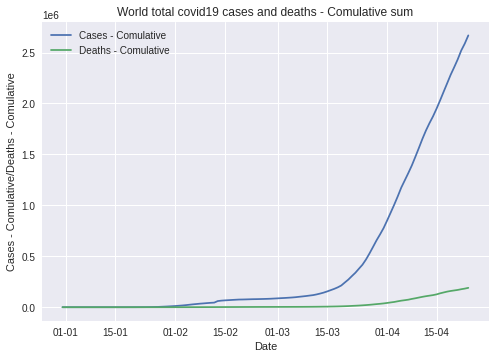

In [17]:
# Show data distribution

# Comulative summary - cases and deaths 

title = "World total covid19 cases and deaths - Comulative sum"
distribution(x = df5.date, xname = "Date", y = df5.comsum_cases, yname = "Cases - Comulative", 
             z = df5.comsum_deaths, zname = "Deaths - Comulative", p_title = title)

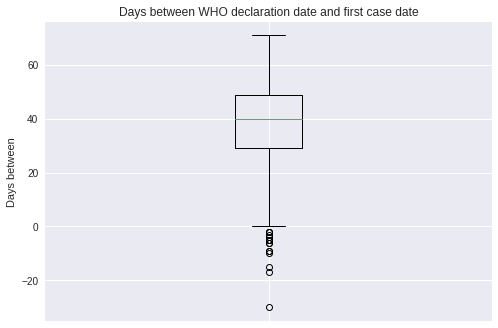

In [18]:
# Avarage time (in days) between the date the "World Health Organization" warnned about the Covid19 epidemic 
# and the date of the first case discovered

# There are also negative values which means that at the time of the WHO announcement, there were already 
# covid19 cases in the country. 

title = "Days between WHO declaration date and first case date"
desc = "Days between"
box_plot(x1 = df2.days_from_declaration, x1name = "", p_title = title, p_desc = desc)

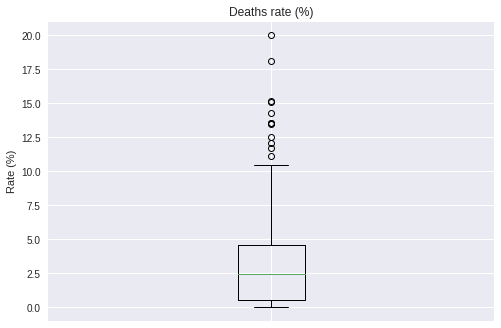

In [19]:
# Percent of deaths of total cases 

title = "Deaths rate (%)"
desc = "Rate (%)"
box_plot(x1 = df2.deaths_percent, x1name = "", p_title = title, p_desc = desc)

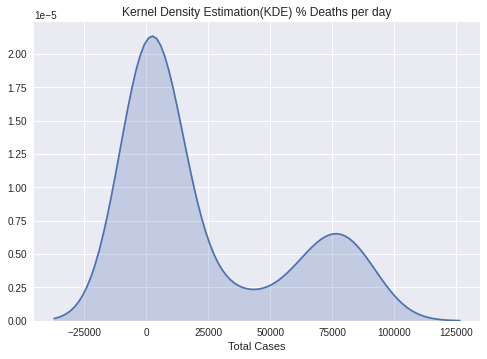

In [672]:
title = "% Deaths per day"
density(x = df4.total_cases, xname = "Total Cases", title = title)

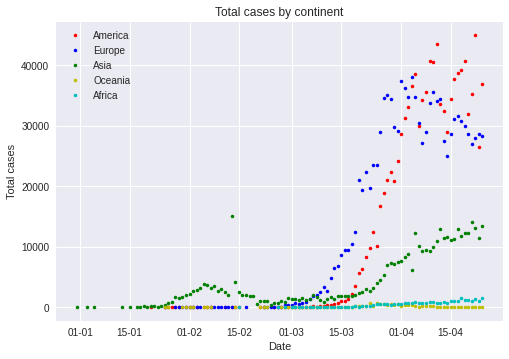

In [594]:
# Cvoid 19 outbreak in the world - Total cases

title = "Total cases by continent"

am  = df6[(df6.continent == "America")]
eur = df6[(df6.continent == "Europe")]
asi = df6[(df6.continent == "Asia")]
oc  = df6[(df6.continent == "Oceania")]
af  = df6[(df6.continent == "Africa")]

scatter(x1 = am.date,  x1name = "",
        x2 = eur.date, x2name = "",
        x3 = asi.date, x3name = "",
        x4 = oc.date,  x4name = "",
        x5 = af.date,  x5name = "",
        y1 = am.total_cases,  y1name = "America",
        y2 = eur.total_cases, y2name = "Europe",
        y3 = asi.total_cases, y3name = "Asia",
        y4 = oc.total_cases , y4name = "Oceania",
        y5 = af.total_cases , y5name = "Africa",
        xlabel = "Date",
        ylabel = "Total cases",
        title = title)

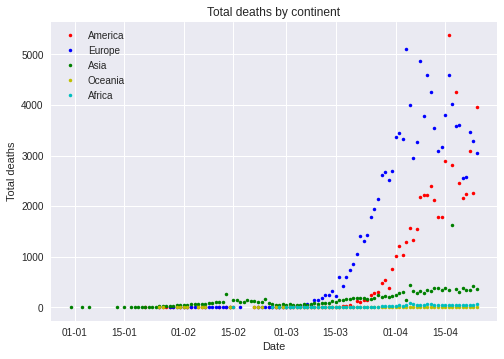

In [595]:
# Cvoid 19 outbreak in the world - Total deaths

# When comparing to the scatter above we can see that America has less deaths related to Europe 
# despite the fact that the number of cases in America is bigger

title = "Total deaths by continent"
scatter(x1 = am.date,  x1name = "",
        x2 = eur.date, x2name = "",
        x3 = asi.date, x3name = "",
        x4 = oc.date,  x4name = "",
        x5 = af.date,  x5name = "",
        y1 = am.total_deaths,  y1name = "America",
        y2 = eur.total_deaths, y2name = "Europe",
        y3 = asi.total_deaths, y3name = "Asia",
        y4 = oc.total_deaths , y4name = "Oceania",
        y5 = af.total_deaths , y5name = "Africa",
        xlabel = "Date",
        ylabel = "Total deaths",
        title = title)

In [601]:
# Read stock data - s&p500 index

t1 = read_stock_data()

In [604]:
# Prepare some stock dataFrames with manipulation and aggregation
#------------------------------------------------------------------

# 1. Create the basic view with stock data
# 2. Calculate rate daily change and delta between high and low rate 
# 3. Aggregate the avarge volume  

t2_sql = ("SELECT date , open, close , high, low, volume, "
          " ((close - open ) / open) * 100 as change_percent, "
          " high - low as delta, "
          " AVG(volume) OVER (order by date) as vol_avg "
               " FROM xx_stock_init_v")

In [605]:
t2 = query_data(p_sql = t2_sql, p_view_name = "xx_stock_v")

print_information(t2)

t2 = t2.toPandas()

Schema :
root
 |-- date: timestamp (nullable = true)
 |-- open: double (nullable = true)
 |-- close: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- volume: long (nullable = true)
 |-- change_percent: double (nullable = true)
 |-- delta: double (nullable = true)
 |-- vol_avg: double (nullable = true)

Number of rows: 84
Example row :
+-------------------+-----------+-----------+-----------+-----------+----------+-------------------+------------------+---------+
|               date|       open|      close|       high|        low|    volume|     change_percent|             delta|  vol_avg|
+-------------------+-----------+-----------+-----------+-----------+----------+-------------------+------------------+---------+
|2020-01-02 00:00:00|3244.669922|3257.850098|3258.139893|3235.530029|3458250000|0.40621007118886365|22.609864000000016|3.45825E9|
+-------------------+-----------+-----------+-----------+-----------+----------+-----------

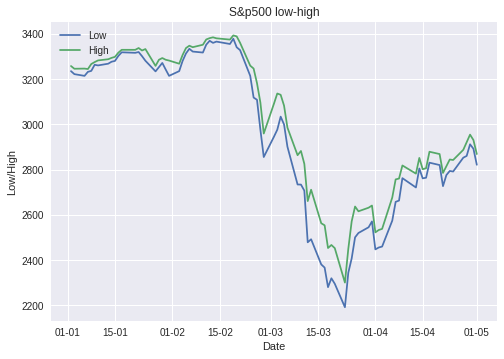

In [606]:
# S&p500low and high rates

title = "S&p500 low-high"
distribution(x = t2.date, xname = "Date", y = t2.low, yname = "Low", z = t2.high, zname = "High", p_title = title)

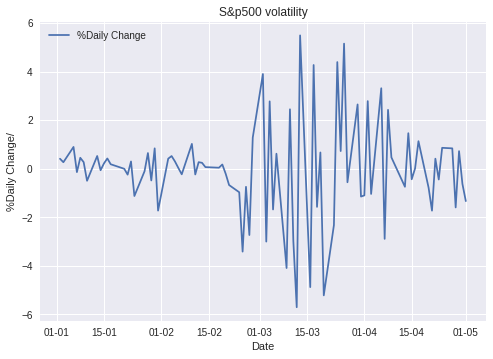

In [607]:
# S&p500 volatility 

title = "S&p500 volatility"
distribution(x = t2.date, xname = "Date", y = t2.change_percent, yname = "%Daily Change",  p_title = title)

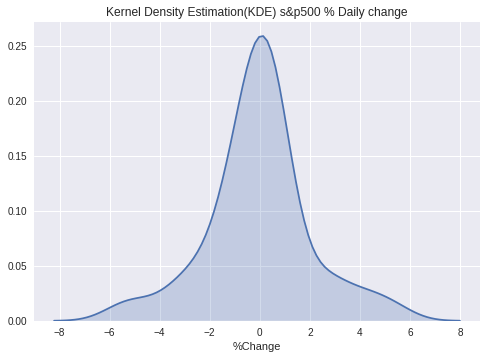

In [609]:
# Show a density estimation plot of rate daily change

# We can see we got a normal distibution around Zero. The explanation might be the fact that
# the market is recovering after declines

title = "s&p500 % Daily change"
density(x = t2.change_percent, xname = "%Change", title = title)

In [611]:
# Read Influenza data file

inf = read_influenza_data()

In [613]:
# Prepare some Influenza dataFrames with manipulation and aggregation
#------------------------------------------------------------------

# 1. Create the basic view with influenza and pneumonia data
# 2. Drop 2009 and 2019 details which are  partial

t3_sql = ("SELECT state, year_week, "
          " NVL(deaths_pneumonia_influenza, 0) as deaths_pneumonia_influenza, all_deaths "
          "FROM xx_influenza_init_v " 
          "WHERE geoid = 'State' "
          " AND substr(year_week, 1, 4) NOT IN ('2009', '2019')"
          " ORDER BY year_week, state")

t3 = query_data(p_sql = t3_sql, p_view_name = "xx_influenza_v")

print_information(t3)

t3 = t3.toPandas()

Schema :
root
 |-- state: string (nullable = true)
 |-- year_week: integer (nullable = true)
 |-- deaths_pneumonia_influenza: integer (nullable = false)
 |-- all_deaths: integer (nullable = true)

Number of rows: 24388
Example row :
+-------+---------+--------------------------+----------+
|  state|year_week|deaths_pneumonia_influenza|all_deaths|
+-------+---------+--------------------------+----------+
|Alabama|   201001|                        89|      1031|
+-------+---------+--------------------------+----------+
only showing top 1 row



In [615]:
# Aggregration by week/year

t4_sql = ("SELECT year_week, concat(substr(year_week, 5, 2), '-', substr(year_week, 1, 4)) as _year_week,  "
          "SUM(deaths_pneumonia_influenza) as deaths_pneumonia_influenza, "
          "SUM(all_deaths) as all_deaths, "
          "SUM(deaths_pneumonia_influenza) / SUM(all_deaths) * 100 as deaths_pneumonia_influenza_percent "
          " FROM xx_influenza_v "     
          " GROUP BY year_week" 
          " ORDER BY year_week")

t4 = query_data(p_sql = t4_sql, p_view_name = "xx_influenza_agr_v")

print_information(t4)

t4=t4.toPandas()

Schema :
root
 |-- year_week: integer (nullable = true)
 |-- _year_week: string (nullable = true)
 |-- deaths_pneumonia_influenza: long (nullable = true)
 |-- all_deaths: long (nullable = true)
 |-- deaths_pneumonia_influenza_percent: double (nullable = true)

Number of rows: 469
Example row :
+---------+----------+--------------------------+----------+----------------------------------+
|year_week|_year_week|deaths_pneumonia_influenza|all_deaths|deaths_pneumonia_influenza_percent|
+---------+----------+--------------------------+----------+----------------------------------+
|   201001|   01-2010|                      4465|     51018|                  8.75181308557764|
+---------+----------+--------------------------+----------+----------------------------------+
only showing top 1 row



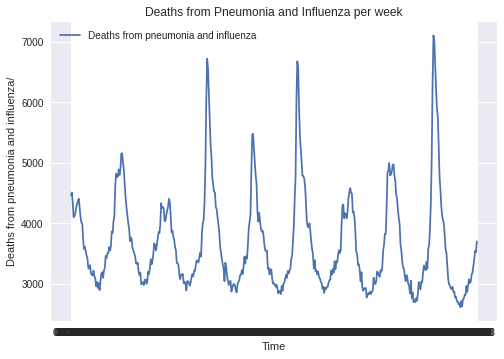

In [619]:
# Show deaths from Pneumonia and Influenza disribution over the years

title = "Deaths from Pneumonia and Influenza per week"
distribution(x = t4._year_week, xname = "Time", y = t4.deaths_pneumonia_influenza, yname = "Deaths from pneumonia and influenza", z = None, zname = "", p_title = title, p_format_date = False)

In [620]:
# Aggregration by year

t5_sql = ("SELECT substr(year_week, 1, 4) as year, "
       "SUM(deaths_pneumonia_influenza) as  deaths_pneumonia_influenza, "
       "SUM(all_deaths) as all_deaths, "
        "SUM(deaths_pneumonia_influenza) / SUM(all_deaths) * 100 as deaths_pneumonia_influenza_percent "
        "FROM xx_influenza_agr_v "
        "GROUP BY substr(year_week, 1, 4) "
        "ORDER BY year")

t5 = query_data(p_sql = t5_sql, p_view_name = "xx_influenza__year_agr_v")

print_information(t5)

t5 = t5.toPandas()

Schema :
root
 |-- year: string (nullable = true)
 |-- deaths_pneumonia_influenza: long (nullable = true)
 |-- all_deaths: long (nullable = true)
 |-- deaths_pneumonia_influenza_percent: double (nullable = true)

Number of rows: 9
Example row :
+----+--------------------------+----------+----------------------------------+
|year|deaths_pneumonia_influenza|all_deaths|deaths_pneumonia_influenza_percent|
+----+--------------------------+----------+----------------------------------+
|2010|                    188453|   2457230|                 7.669326843641009|
+----+--------------------------+----------+----------------------------------+
only showing top 1 row



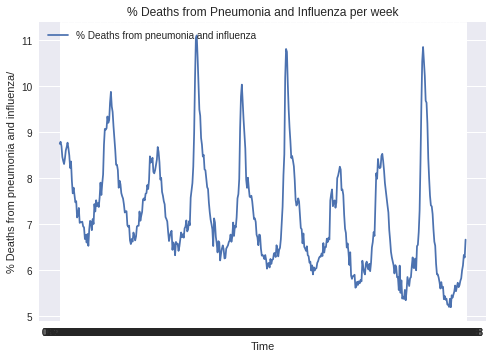

In [621]:
# Percent of deaths from Pneumonia and Influenza of all deaths

title = "% Deaths from Pneumonia and Influenza per week"
distribution(x = t4._year_week, xname = "Time", y = t4.deaths_pneumonia_influenza_percent, yname = "% Deaths from pneumonia and influenza", z = None, zname = "", p_title = title, p_format_date = False)

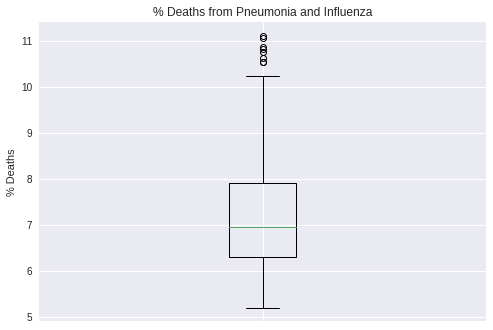

In [623]:
# Percent of deaths from Pneumonia and Influenza of all deaths

title = "% Deaths from Pneumonia and Influenza"
desc = "% Deaths"
box_plot(x1 = t4.deaths_pneumonia_influenza_percent, x1name = "", p_title = title, p_desc =  desc)

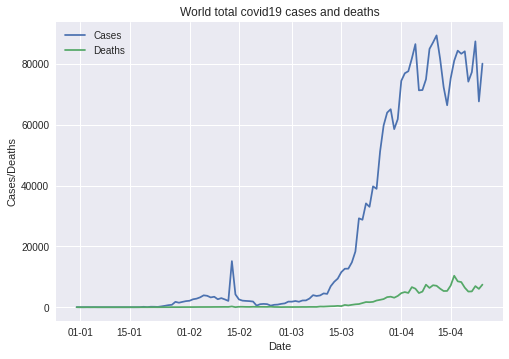

In [624]:
# Lets try to find interesting correlation between Covid19 outbreak and s&p500 index

title = "World total covid19 cases and deaths"
distribution(x = df5.date, xname = "Date", y = df5.total_cases, yname = "Cases", 
             z = df5.total_deaths, zname = "Deaths", p_title = title)

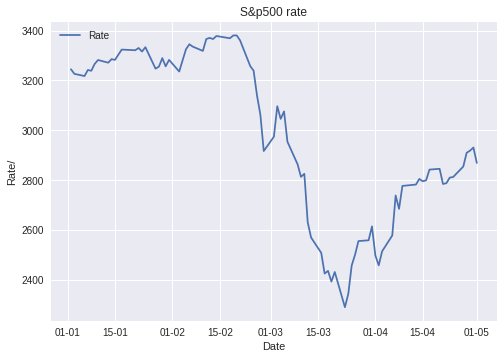

In [625]:
title = "S&p500 rate"
distribution(x = t2.date, xname = "Date", y = t2.open, yname = "Rate", p_title = title)

In [ ]:
# We can see that between 1.3.20 and 1.4.20 which is the peak of the Covid19 outbreak, 
# The s&p500 rate declined 

# We can also see in te next plot that between those dates, also the trading volume increased very much

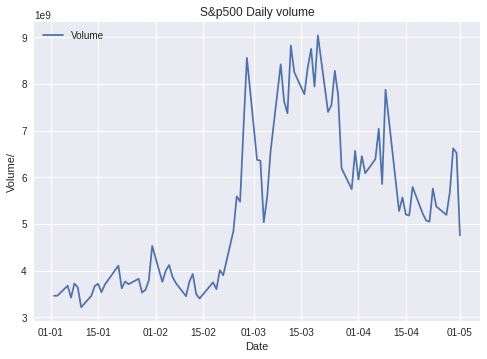

In [626]:
title = "S&p500 Daily volume"
distribution(x = t2.date, xname = "Date", y = t2.volume, yname = "Volume", p_title = title)

In [628]:
# We can also see in the next plot that between those dates, also the delta between low and high rate increased
# related to normal days . This is the "Nervousness Index" of the market

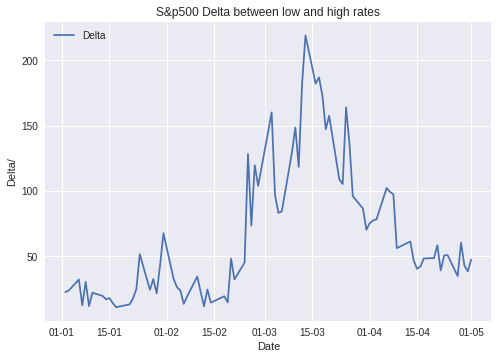

In [629]:
title = "S&p500 Delta between low and high rates"
distribution(x = t2.date, xname = "Date", y = t2.delta, yname = "Delta", p_title = title)

In [640]:
# Let's build a new table and try to visualize the correlation between Covid19 outbreask and market rate

a1_sql = ("SELECT total_cases as covid19_cases,  xx_stock_v.open as sp_500rate"
          " FROM xx_covid19_date_comsum_v "
              "   INNER JOIN xx_stock_v  "
          "ON xx_covid19_date_comsum_v.date = xx_stock_v.date "
          "WHERE xx_covid19_date_comsum_v.date < TO_DATE('01-04-2020', 'dd-MM-yyyy') "
          " ORDER BY xx_covid19_date_comsum_v.date"
         )

a1 = query_data(p_sql = a1_sql, p_view_name = "xx_model_v")

print_information(a1)

m = a1 #Model

a1 = a1.toPandas()

Schema :
root
 |-- covid19_cases: long (nullable = true)
 |-- sp_500rate: double (nullable = true)

Number of rows: 62
Example row :
+-------------+-----------+
|covid19_cases| sp_500rate|
+-------------+-----------+
|            0|3244.669922|
+-------------+-----------+
only showing top 1 row



In [ ]:
# We can see in the next plot that the s&p500 rate was decreased 
#  as far as the number of Covid19 cases around the world was increased 

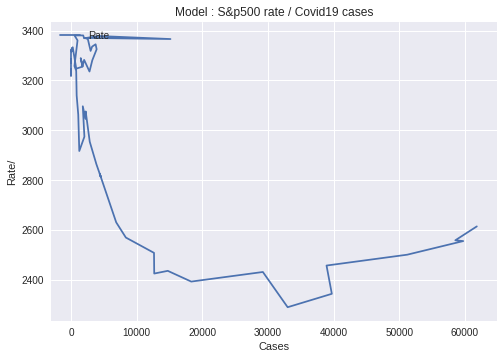

In [642]:
title = "Model : S&p500 rate / Covid19 cases"
distribution(x = a1.covid19_cases, xname = "Cases", y = a1.sp_500rate, yname = "Rate", p_title = title, p_format_date = False)

In [ ]:
#Lets try to run a Linear regression on those fields

In [636]:
from pyspark.mllib.linalg import Vectors, Vector
from pyspark.mllib.linalg import Matrices

In [643]:
# Convert DataFrame to RDD object
m = m.rdd

In [644]:
m.take(20)

[Row(covid19_cases=0, sp_500rate=3244.669922),
 Row(covid19_cases=17, sp_500rate=3226.360107),
 Row(covid19_cases=0, sp_500rate=3217.550049),
 Row(covid19_cases=0, sp_500rate=3241.860107),
 Row(covid19_cases=0, sp_500rate=3238.590088),
 Row(covid19_cases=0, sp_500rate=3266.030029),
 Row(covid19_cases=0, sp_500rate=3281.810059),
 Row(covid19_cases=1, sp_500rate=3271.129883),
 Row(covid19_cases=0, sp_500rate=3285.350098),
 Row(covid19_cases=1, sp_500rate=3282.27002),
 Row(covid19_cases=0, sp_500rate=3302.969971),
 Row(covid19_cases=5, sp_500rate=3323.659912),
 Row(covid19_cases=153, sp_500rate=3321.030029),
 Row(covid19_cases=142, sp_500rate=3330.02002),
 Row(covid19_cases=97, sp_500rate=3315.77002),
 Row(covid19_cases=266, sp_500rate=3333.100098),
 Row(covid19_cases=797, sp_500rate=3247.159912),
 Row(covid19_cases=1767, sp_500rate=3255.350098),
 Row(covid19_cases=1480, sp_500rate=3289.459961),
 Row(covid19_cases=1756, sp_500rate=3256.449951)]

In [645]:
# Convert list to array
import numpy as np
m = m.map(lambda x: np.array(x))

In [646]:
m.take(20)

[array([   0.      , 3244.669922]),
 array([  17.      , 3226.360107]),
 array([   0.      , 3217.550049]),
 array([   0.      , 3241.860107]),
 array([   0.      , 3238.590088]),
 array([   0.      , 3266.030029]),
 array([   0.      , 3281.810059]),
 array([1.00000000e+00, 3.27112988e+03]),
 array([   0.      , 3285.350098]),
 array([1.00000000e+00, 3.28227002e+03]),
 array([   0.      , 3302.969971]),
 array([   5.      , 3323.659912]),
 array([ 153.      , 3321.030029]),
 array([ 142.     , 3330.02002]),
 array([  97.     , 3315.77002]),
 array([ 266.      , 3333.100098]),
 array([ 797.      , 3247.159912]),
 array([1767.      , 3255.350098]),
 array([1480.      , 3289.459961]),
 array([1756.      , 3256.449951])]

In [647]:
#Create dense vectors
Vals = m.map(lambda x: Vectors.dense([float(v) for v in x]))
Vals.take(2)

[DenseVector([0.0, 3244.6699]), DenseVector([17.0, 3226.3601])]

In [ ]:
## Analyzing data distribution
## We will use the RowMatrix objec to calculate its multivariance statistics

In [648]:
from pyspark.mllib.linalg.distributed import RowMatrix
Mat = RowMatrix(Vals)
print(Mat)

In [649]:
from pyspark.mllib.stat._statistics import Statistics
Stats = Statistics.colStats(Vals)
Stats.variance()

array([2.51310646e+08, 1.19235500e+05])

In [651]:
Stats.normL1() 
print(Stats.normL2())
Stats

[141052.88618812  24230.99365301]


In [653]:
# Determide label point

from pyspark.mllib.regression import LabeledPoint

def toLabeledPoint(x):
    a = x.toArray()
    return LabeledPoint(a[-1], Vectors.dense(a[0:-1]))

In [654]:
Data = Vals.map(toLabeledPoint)

In [656]:
# Splits the data to train and test (80/20 ratio) 

sets = Data.randomSplit([0.8, 0.2])
Train = sets[0]
Valid = sets[1]

In [657]:
print(Train.count())
print(Valid.count())

43
19


In [658]:
Valid.take(10)

[LabeledPoint(3266.030029, [0.0]),
 LabeledPoint(3281.810059, [0.0]),
 LabeledPoint(3271.129883, [1.0]),
 LabeledPoint(3302.969971, [0.0]),
 LabeledPoint(3330.02002, [142.0]),
 LabeledPoint(3247.159912, [797.0]),
 LabeledPoint(3289.459961, [1480.0]),
 LabeledPoint(3235.659912, [2818.0]),
 LabeledPoint(3280.610107, [3243.0]),
 LabeledPoint(3318.280029, [2988.0])]

In [659]:
Train.take(10)

[LabeledPoint(3244.669922, [0.0]),
 LabeledPoint(3226.360107, [17.0]),
 LabeledPoint(3217.550049, [0.0]),
 LabeledPoint(3241.860107, [0.0]),
 LabeledPoint(3238.590088, [0.0]),
 LabeledPoint(3285.350098, [0.0]),
 LabeledPoint(3282.27002, [1.0]),
 LabeledPoint(3323.659912, [5.0]),
 LabeledPoint(3321.030029, [153.0]),
 LabeledPoint(3315.77002, [97.0])]

In [660]:
# Normalization of the data

from pyspark.mllib.feature import StandardScaler
scaler = StandardScaler(True, True).fit(Train.map(lambda x: x.features))

In [661]:
trainLabel = Train.map(lambda x: x.label)
trainFeatures = Train.map(lambda x: x.features)
validLabel = Valid.map(lambda x: x.label)
validFeatures = Valid.map(lambda x: x.features)

In [662]:
scaler.transform(trainFeatures).take(2)

[DenseVector([-0.551]), DenseVector([-0.55])]

In [663]:
trainLabel.zip(scaler.transform(trainFeatures)).take(2)

[(3244.669922, DenseVector([-0.551])), (3226.360107, DenseVector([-0.55]))]

In [664]:
#The zip function is used to combine two RDDs into the RDD of the Key / Value form.

trainScaled = trainLabel.zip(scaler.transform(trainFeatures)).map(lambda x: LabeledPoint(x[0], x[1]))
validScaled = validLabel.zip(scaler.transform(validFeatures)).map(lambda x: LabeledPoint(x[0], x[1]))

In [665]:
# Run the machine learning.
# We will cashe the train and value sets because the algorithm will use it by 200 iterations

from pyspark.mllib.regression import LinearRegressionWithSGD
alg = LinearRegressionWithSGD()
trainScaled.cache()
validScaled.cache()

#Lets train the model 
model = alg.train(trainScaled, iterations=200, intercept=True)

In [666]:
validPredicts = validScaled.map(lambda x: (float(model.predict(x.features)), x.label))
validPredicts.collect()

[(3146.776406091112, 3266.030029),
 (3146.776406091112, 3281.810059),
 (3146.763426121136, 3271.129883),
 (3146.776406091112, 3302.969971),
 (3144.9332503544774, 3330.02002),
 (3136.4313700200005, 3247.159912),
 (3127.5660505261867, 3289.459961),
 (3110.198850697896, 3235.659912),
 (3104.682363457968, 3280.610107),
 (3107.992255801925, 3318.280029),
 (3113.4827831019, 3365.870117),
 (3119.8819083002168, 3370.5),
 (3133.8483559947163, 3360.5),
 (3139.9359619136017, 3257.610107),
 (3135.5746920015645, 3139.899902),
 (3117.714253314174, 3075.699951),
 (2718.4633568131317, 2290.709961),
 (2631.121138842602, 2344.439941),
 (2641.6089545834534, 2457.77002)]

In [670]:
# Lets check the root mean square error

import math
RSME = math.sqrt(validPredicts.map(lambda p: pow(p[0]-p[1], 2)).mean())

In [671]:
RSME

195.80135239037264